In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join("../..")))
sys.path.append(os.path.abspath(os.path.join("../scripts")))

In [3]:
from DistributionPlots import DistributionPlots
DP = DistributionPlots() 

In [4]:
from ABTestingFunctions import ABTesting
ABtest = ABTesting()

In [5]:
data = pd.read_csv("../data/AdSmartClean_data.csv")

In [6]:
data.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
1,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
2,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
3,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
4,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


In [7]:
# awareness rate in each experiment is the ratio of 'yes' responses to the total number of participants
# first we aggregate the data for each experiment, and get the total number of responses and number of positive responses

results = data.groupby('experiment')[['auction_id', 'yes']].agg({'auction_id': 'count','yes': 'sum' })
results.rename(columns = {'auction_id':'total'}, inplace=True)
results.reset_index(inplace=True)
results

,experiment,total,yes
0,control,586,264
1,exposed,657,308


In [8]:
# Second we add a column with the awarness rate

results['a_rate'] = results.yes/results.total
results

,experiment,total,yes,a_rate
0,control,586,264,0.450512
1,exposed,657,308,0.468798


# Classical A/B Testing

In [9]:
# BCR = baseline conversion rate, it is the rate of the desired effect in the control group

bcr = results[results.experiment == 'control'].a_rate[0]
print('bcr = {:.4f} = {:.2f}%'.format(bcr, bcr*100))

bcr = 0.4505 = 45.05%


In [10]:
## We set the desired lift, how much improvement we would like the SmartAd champain to affect, minimum detectable effect
# mde = 0.02

# Conversion rate in Exposed Group
ecr = results[results.experiment == 'exposed'].a_rate[1]

# The improvement in conversion/awareness rate, in exposed grouped as compared to the control
mde = ecr - bcr
print('Awareness raised by {:.4f} = {:.2f}%'.format(mde, mde*100))

Awareness raised by 0.0183 = 1.83%


In [11]:
# Number of users in the control and exposed groups
C_total = results[results.experiment == 'control'].total[0]
E_total = results[results.experiment == 'exposed'].total[1]


C_aware = results[results.experiment == 'control'].yes[0]
E_aware = results[results.experiment == 'exposed'].yes[1]

## 1. Compare Control and Exposed Distribution

The assumption is that both the control & exposed can be modeled by a binomial distribution.

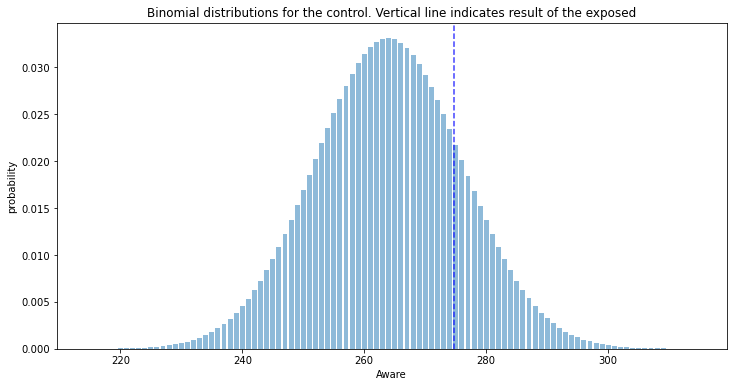

In [12]:
#control group distribution with probability of getting the result from our exposed group
DP.cont_distribution(C_aware, C_total, bcr, ecr)

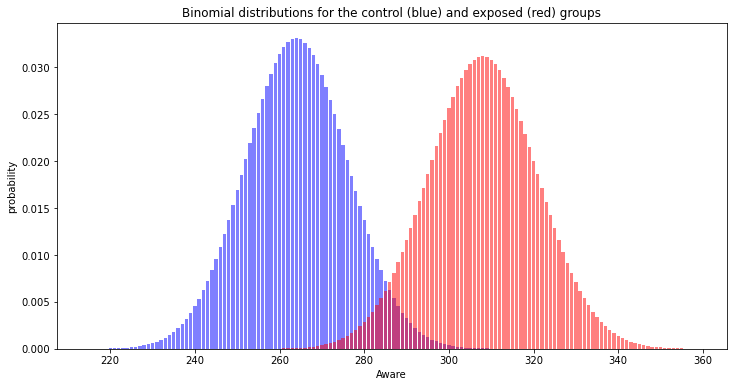

In [13]:
#comparison of control and exposed groups distribution against each other
DP.cont_exp_distribution(C_aware, E_aware, C_total, E_total, bcr, ecr)

## 2. Compare the Null Hypothesis vs. the Alternative Hypothesis

- The null hypothesis is the position that SmartAd's ad shown to the exposed group would result in no change in the awareness rate of the users.
- The alternative hypothesis is the opposing position that SmartAd's ad shown to the exposed group would result in an improvement (or reduction) in the awareness rate of the users.

The null hypothesis will be a normal distribution with a mean of zero, the alternative hypothesis will be a normal distribution with a mean located at the difference in the awareness rate, d_hat.
Both distributions will have a standard deviation equal to the pooled standard error

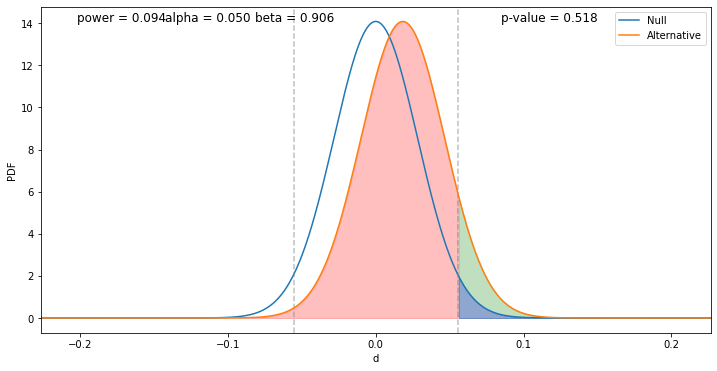

In [14]:
#Null and alternative hypotheses plots with
# statistical power and significance levels defined and represented in the plots
DP.null_alt_distribution(C_total, E_total, bcr, ecr)

The **p-value** is 0.518 = 51.8%. Much bigger than significance level we chose 

The improvement in users' awareness caused by SmartAd campaign is **not** statistically significant. The null hypothesis is not rejected.

## 3. Interpreting the results: Sample Size

The effect of SmartAd campaign on users' awareness could still be real, despite our result. However the test, with it small sample size, is not able to reasonablly prove that. 

Q: How much bigger should the sample size be?

A: In the following we compute the minimum sample size required to detect the same effect (given by mde), with significance level 5% and statistical power 80%.

In [15]:
# Minmum sample size

n_min = ABtest.min_sample_size(bcr, mde, power=0.8, sig_level=0.05)

print('Minimum sample size to detect an improvement of {:.2f}% in users\' awareness\
rate is {:.0f}'.format(mde *100, n_min))

print('current sample size is {}'.format(C_total+E_total))

Minimum sample size to detect an improvement of 1.83% in users' awarenessrate is 11661
current sample size is 1243
